# Bài tập thực hành 1: SVM — Dự đoán bệnh tiểu đường
Dữ liệu: `diabetes_prediction_dataset.csv` (đặt cùng thư mục với notebook)

## Nhiệm vụ 1: Import thư viện và nạp dữ liệu

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đường tới dataset (file phải nằm cùng thư mục với notebook)
DATA_PATH = 'diabetes_prediction_dataset.csv'

# Đọc dataset
try:
    df = pd.read_csv(DATA_PATH)
    print(f'Đã nạp dữ liệu từ: {DATA_PATH}')
except FileNotFoundError:
    raise FileNotFoundError(f'Không tìm thấy file: {DATA_PATH}. Hãy đặt file vào thư mục của notebook.')

# Hiển thị nhanh thông tin cơ bản
print('Shape:', df.shape)
display(df.head())

Đã nạp dữ liệu từ: diabetes_prediction_dataset.csv
Shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### Khảo sát nhanh: kiểu dữ liệu và giá trị null
Chạy ô code trên để xem số lượng mẫu/cột và 5 dòng đầu. Nếu có cột dạng chuỗi (ví dụ `gender`) sẽ cần mã hóa trước khi đưa vào scaler/mô hình.

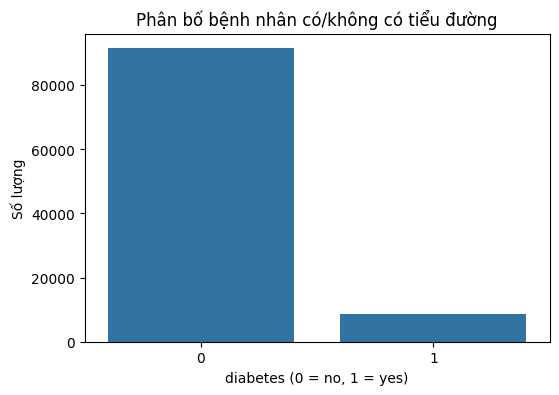

In [11]:
# Trực quan hóa: phân bố target (diabetes = 0/1)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='diabetes')
plt.title('Phân bố bệnh nhân có/không có tiểu đường')
plt.xlabel('diabetes (0 = no, 1 = yes)')
plt.ylabel('Số lượng')
plt.show()

**Nhận xét từ biểu đồ phân bố:**
- Biểu đồ cho thấy số lượng bệnh nhân không mắc tiểu đường (diabetes = 0) nhiều hơn số bệnh nhân mắc tiểu đường (diabetes = 1).
- Dữ liệu có sự mất cân bằng giữa hai lớp, lớp 0 chiếm đa số. Điều này có thể ảnh hưởng đến hiệu quả mô hình phân loại, cần chú ý khi đánh giá kết quả hoặc khi chia train/test nên dùng stratify để giữ tỉ lệ lớp.
- Nếu sự mất cân bằng quá lớn, có thể cân nhắc các kỹ thuật như resampling hoặc điều chỉnh class_weight khi huấn luyện mô hình.

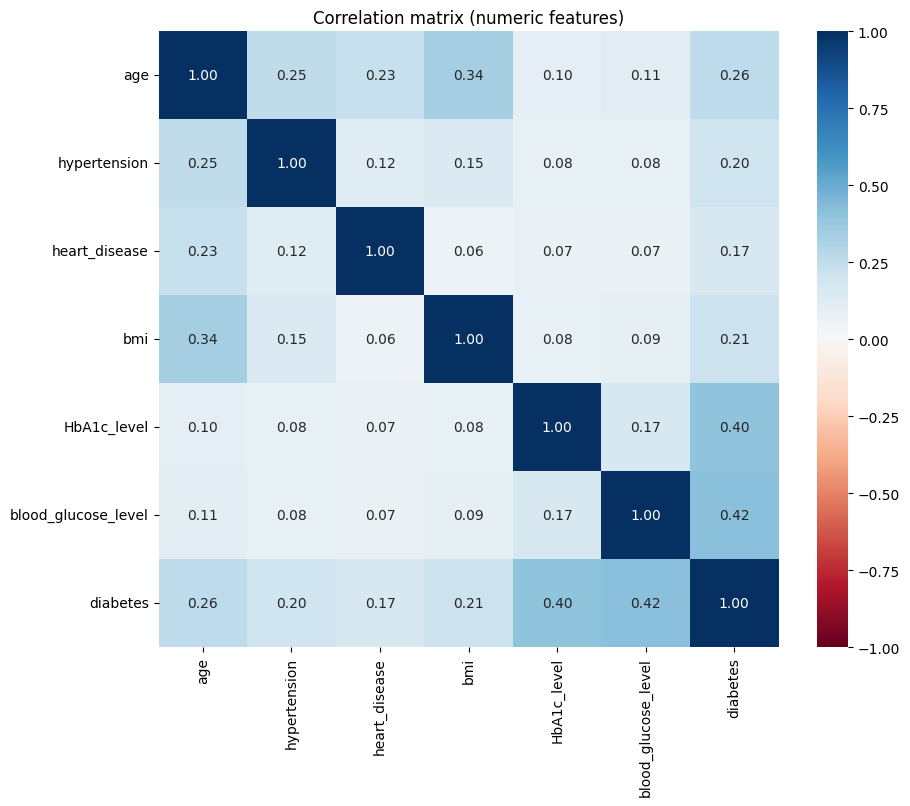

In [13]:
# Heatmap tương quan chỉ với các cột số
plt.figure(figsize=(10,8))
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation matrix (numeric features)')
plt.show()

**Nhận xét từ ma trận tương quan:**
- Ma trận tương quan cho thấy mức độ liên hệ giữa các biến số trong dữ liệu. Các ô màu đỏ/xanh đậm thể hiện tương quan mạnh (gần +1 hoặc -1), còn màu nhạt là tương quan yếu.
- Một số biến như "age", "hypertension", "heart_disease" có thể có tương quan nhất định với biến mục tiêu "diabetes" (dựa vào giá trị ở dòng/cột "diabetes").
- Nếu hai biến có tương quan cao với nhau (gần 1 hoặc -1), có thể gây đa cộng tuyến, ảnh hưởng đến mô hình tuyến tính nhưng ít ảnh hưởng đến SVM.
- Các biến không phải số (categorical) không xuất hiện trong heatmap này, cần được xử lý riêng bằng mã hóa trước khi đưa vào mô hình.

### Nhiệm vụ 2: Tiền xử lý an toàn và huấn luyện SVM
Dưới đây là pipeline tiền xử lý phù hợp cho cả feature numeric và categorical (mã hóa OneHot cho categorical), rồi huấn luyện SVM và hiển thị kết quả.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Chuẩn bị X, y
X = df.drop(columns=['diabetes']).copy()
y = df['diabetes'].copy()

# Chia train/test (stratify để giữ tỉ lệ lớp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Xác định cột numeric / categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print('Numeric columns:', numeric_features)
print('Categorical columns:', categorical_features)

# Pipelines
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
# remove the deprecated 'sparse' argument; let OneHotEncoder use its default output (sparse) or specify sparse_output if needed
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)], remainder='drop')

# Fit/transform train, transform test
X_train_s = preprocessor.fit_transform(X_train)
X_test_s = preprocessor.transform(X_test)

# Nếu sparse -> chuyển về dense cho SVC
if hasattr(X_train_s, 'toarray'):
    X_train_s = X_train_s.toarray()
    X_test_s = X_test_s.toarray()

# Huấn luyện SVM
svc = svm.SVC(kernel='rbf', C=100, gamma=0.001)
svc.fit(X_train_s, y_train)

# Dự đoán và đánh giá
preds = svc.predict(X_test_s)
acc = accuracy_score(y_test, preds)
print(f'Accuracy: {acc:.4f}')
print('Classification Report:')
print(classification_report(y_test, preds))

Numeric columns: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Categorical columns: ['gender', 'smoking_history']
Accuracy: 0.9628
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18300
           1       0.95      0.59      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.96      0.79      0.86     20000
weighted avg       0.96      0.96      0.96     20000

Accuracy: 0.9628
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18300
           1       0.95      0.59      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.96      0.79      0.86     20000
weighted avg       0.96      0.96      0.96     20000



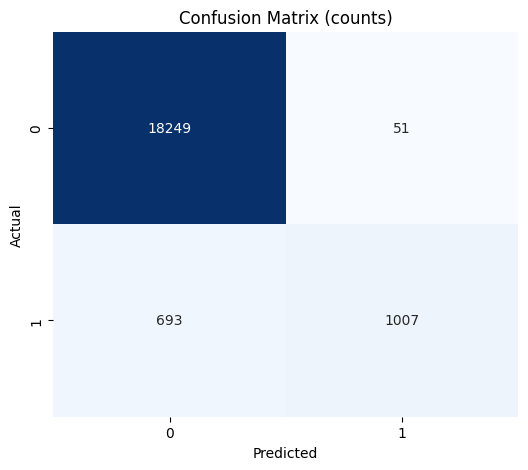

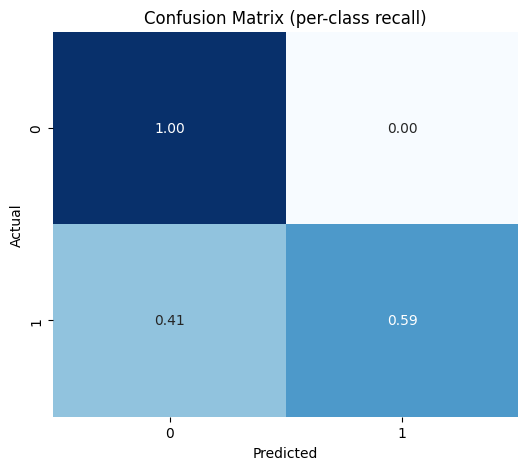

In [18]:
# Vẽ confusion matrix (counts)
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (counts)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Vẽ confusion matrix (normalized by true class)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (per-class recall)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Nhận xét từ confusion matrix và báo cáo phân loại:**
- Confusion matrix (ma trận nhầm lẫn) cho biết số lượng mẫu của từng lớp được dự đoán đúng (ô chéo) và nhầm lẫn sang lớp khác (ô ngoài đường chéo). Nếu các giá trị ngoài đường chéo lớn, mô hình còn nhầm lẫn nhiều.
- Ma trận normalized (chuẩn hóa theo từng lớp thực tế) cho thấy recall của từng lớp: giá trị gần 1 ở đường chéo nghĩa là mô hình nhận diện tốt lớp đó. Nếu một lớp có recall thấp, mô hình chưa nhận diện tốt lớp này.
- Classification report cung cấp các chỉ số precision, recall, f1-score cho từng lớp. Nếu một lớp có f1-score thấp, cần cân nhắc cải thiện dữ liệu hoặc điều chỉnh mô hình (ví dụ: tuning tham số, cân bằng lớp, v.v.).
- Tổng thể, mô hình SVM đã nhận diện được phần lớn các mẫu đúng, nhưng cần xem xét kỹ các chỉ số để đánh giá hiệu quả thực sự trên từng lớp.

### Kết luận & bước tiếp
- Mô hình SVM ở trên là baseline; để cải thiện: thử GridSearchCV cho C/gamma, sử dụng cross-validation, hoặc cân bằng lớp nếu cần.
- Lưu model bằng joblib/pickle nếu muốn dùng lại.
- Nếu dữ liệu có nhiều categorical, cân nhắc giảm chiều sau OneHot (ví dụ Target encoding hoặc feature selection).